---



## 9. Solutions

Open after you try Section 8.

### Solution 8.1

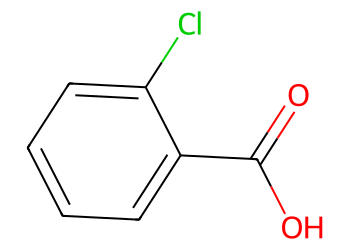

rings: <rdkit.rdBase._vectclass std::vector<int,class std::allocator<int> > object at 0x00000229A36CF9C0>
bond 0 0 - 1 order 2
bond 1 1 - 2 order 1
bond 2 1 - 3 order 1
bond 3 3 - 4 order 1
bond 4 4 - 5 order 1
bond 5 5 - 6 order 1
bond 6 6 - 7 order 1
bond 7 7 - 8 order 1
bond 8 8 - 9 order 1
bond 9 8 - 3 order 1


In [1]:
from rdkit import Chem
from rdkit.Chem import Draw

smi = "O=C(O)c1ccccc1Cl"

mol = Chem.MolFromSmiles(smi)
display(Draw.MolToImage(mol, size=(350, 250), includeAtomNumbers=True))

num_rings = Chem.GetSSSR(mol)
print("rings:", num_rings)

for b in mol.GetBonds():
    print("bond", b.GetIdx(), b.GetBeginAtomIdx(), "-", b.GetEndAtomIdx(), "order", int(b.GetBondTypeAsDouble()))

### Solution 8.2

In [2]:
import pandas as pd
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors

names = ["Cn1cnc2N(C)C(=O)N(C)C(=O)c12", "CC(=O)Nc1ccc(O)cc1", "CC(C)Cc1ccc(cc1)C(C)C(O)=O"]
rows = []
for nm in names:
    m = Chem.MolFromSmiles(nm)
    rows.append({
        "smiles": nm,
        "MolWt": Descriptors.MolWt(m),
        "LogP": Crippen.MolLogP(m),
        "HBD": rdMolDescriptors.CalcNumHBD(m),
        "HBA": rdMolDescriptors.CalcNumHBA(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m)
    })

pd.DataFrame(rows)

,smiles,MolWt,LogP,HBD,HBA,TPSA
0,Cn1cnc2N(C)C(=O)N(C)C(=O)c12,194.194,-1.0293,0,6,61.82
1,CC(=O)Nc1ccc(O)cc1,151.165,1.3506,2,2,49.33
2,CC(C)Cc1ccc(cc1)C(C)C(O)=O,206.285,3.0732,1,1,37.30


### Solution 8.3

O=C(O)c1ccc(F)cc1


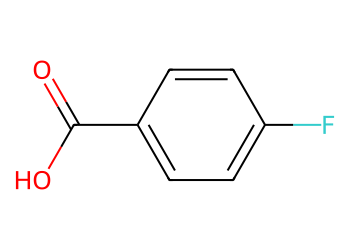

In [3]:
find = Chem.MolFromSmiles("Cl")
put  = Chem.MolFromSmiles("F")
mol  = Chem.MolFromSmiles("Clc1ccc(cc1)C(=O)O")
out  = Chem.ReplaceSubstructs(mol, find, put, replaceAll=True)[0]
print(Chem.MolToSmiles(out))
Draw.MolToImage(out, size=(350, 250))

### Solution 8.4

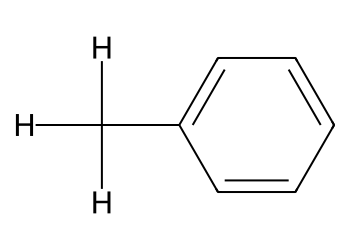

In [4]:
mol = Chem.MolFromSmiles("c1ccccc1")
em = Chem.EditableMol(mol)

idx_C = em.AddAtom(Chem.Atom("C"))
idx_H1 = em.AddAtom(Chem.Atom("H"))
idx_H2 = em.AddAtom(Chem.Atom("H"))
idx_H3 = em.AddAtom(Chem.Atom("H"))

em.AddBond(2, idx_C, order=Chem.BondType.SINGLE)
em.AddBond(idx_C, idx_H1, order=Chem.BondType.SINGLE)
em.AddBond(idx_C, idx_H2, order=Chem.BondType.SINGLE)
em.AddBond(idx_C, idx_H3, order=Chem.BondType.SINGLE)

mol2 = em.GetMol()
Chem.SanitizeMol(mol2)
Draw.MolToImage(mol2, size=(350, 250), includeAtomNumbers=True)

### Solution 8.5

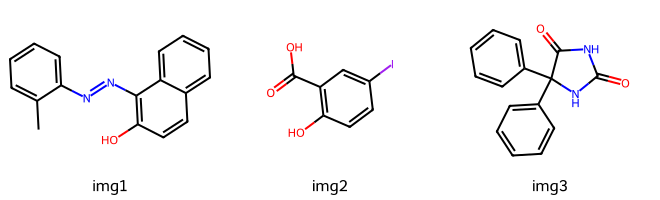

In [5]:
# Paste the SMILES you obtained from PubChem Draw structure
smi1 = "CC1=CC=CC=C1N=NC2=C(C=CC3=CC=CC=C32)O"  # for image 1
smi2 = "C1=CC(=C(C=C1I)C(=O)O)O"  # for image 2
smi3 = "C1=CC=C(C=C1)C2(C(=O)NC(=O)N2)C3=CC=CC=C3"  # for image 3

m1 = Chem.MolFromSmiles(smi1)
m2 = Chem.MolFromSmiles(smi2)
m3 = Chem.MolFromSmiles(smi3)

Draw.MolsToGridImage([m1, m2, m3], legends=["img1","img2","img3"], molsPerRow=3, subImgSize=(220,200), useSVG=True)

In [6]:
# Compute quick properties for the three molecules
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
import pandas as pd

def props(m):
    return dict(
        MolWt=Descriptors.MolWt(m),
        LogP=Crippen.MolLogP(m),
        HBD=rdMolDescriptors.CalcNumHBD(m),
        HBA=rdMolDescriptors.CalcNumHBA(m),
        TPSA=rdMolDescriptors.CalcTPSA(m)
    )

df = pd.DataFrame([
    {"name":"img1","smiles":smi1, **props(m1)},
    {"name":"img2","smiles":smi2, **props(m2)},
    {"name":"img3","smiles":smi3, **props(m3)}
]).round(3)

df

,name,smiles,MolWt,LogP,HBD,HBA,TPSA
0,img1,CC1=CC=CC=C1N=NC2=C(C=CC3=CC=CC=C32)O,262.312,5.269,1,3,44.95
1,img2,C1=CC(=C(C=C1I)C(=O)O)O,264.018,1.695,2,2,57.53
2,img3,C1=CC=C(C=C1)C2(C(=O)NC(=O)N2)C3=CC=CC=C3,252.273,1.770,2,2,58.20
